<a href="https://colab.research.google.com/github/jaroslawkrol/vision-camera-realtime-object-detection/blob/main/Retrain_EfficientDet_for_the_React_Native_with_TensorFlow_Lite_Model_Maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrain EfficientDet for the React Native with TensorFlow Lite Model Maker

In this tutorial, we'll retrain the EfficientDet-Lite object detection model (derived from [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html)) using the [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/guide/model_maker) for React Native App purpose. 

This tutorial is part of an article [From Trash to Treasure: Using Machine Learning to Recognize Garbage Type with React Native and TensorFlow](). According to the article, at this stage you should have a dataset of images prepared, which we will use to retrain our model. 

Here's an example training results for dataset contains over 900 photos:

## Import the required packages

In [ ]:
!pip install -q tflite-model-maker

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Load the training data 

1. Be sure thah dataset is annotated in Pascal VOC XML (various tools can help create VOC annotations, such as LabelImg). Then create a ZIP file with all your JPG images and XML files (JPG and XML files can all be in one directory or in separate directories).
2. Click the Files tab in the left panel
3. Click upload icon and select the zip archive from your device which contains prepared dataset

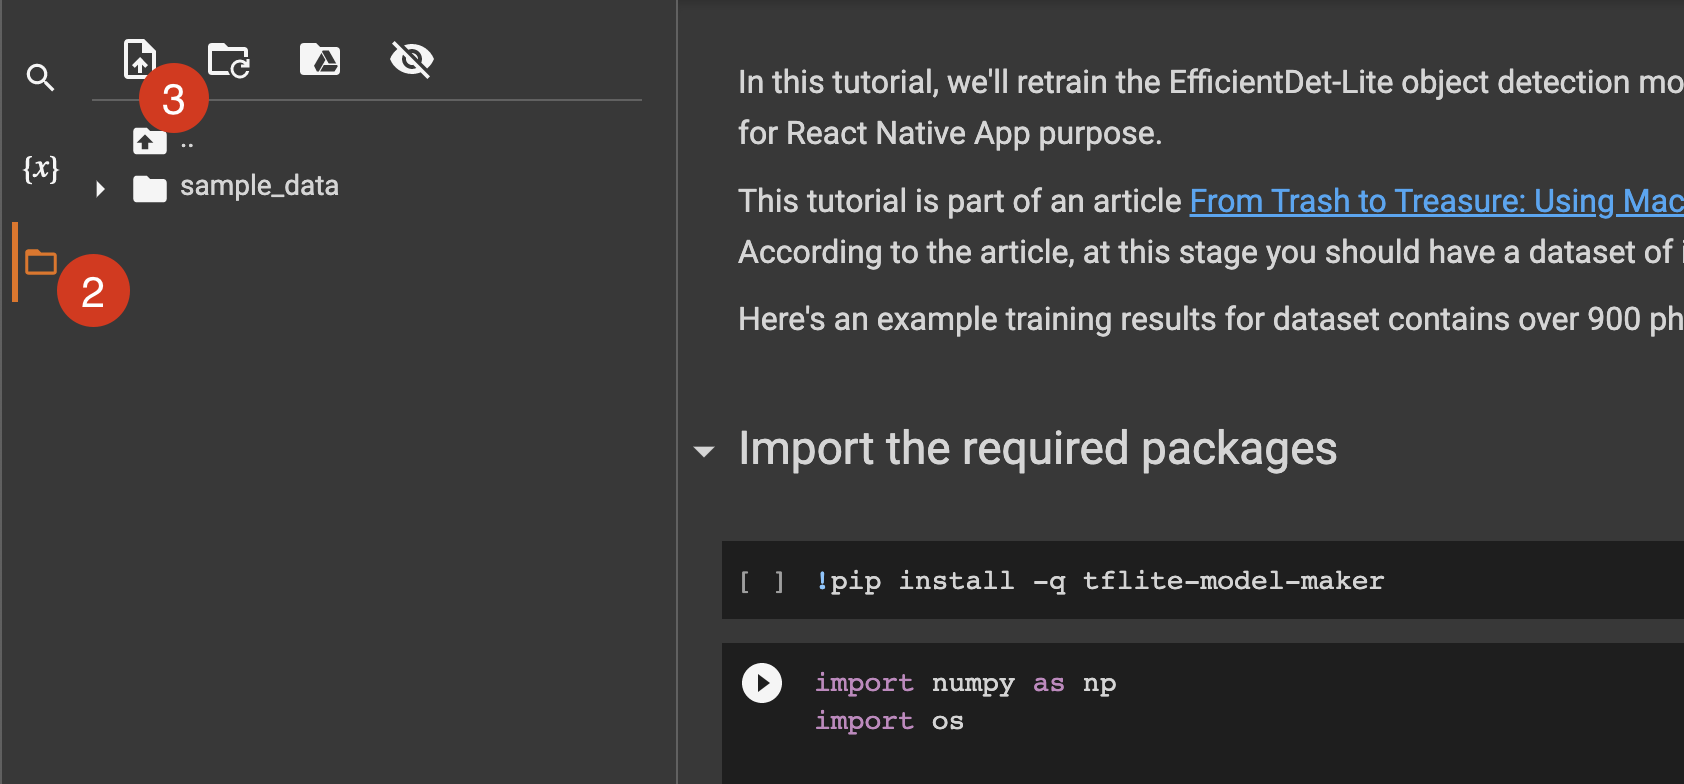

## Load your own Pascal VOC dataset

To use your custom dataset, you need to modify a few variables here, such as your ZIP filename, your label map, and the path to your images/annotations:

In [ ]:
# The ZIP file you uploaded:
!unzip garbage_dataset.zip

# Your labels map as a dictionary (zero is reserved):
label_map = {1: 'plastic', 2: 'glass', 3: 'metal', 5: 'paper', 6: 'trash'} 

images_in = 'dataset/images'
annotations_in = 'datatset/annotations'

The last step before starting to create the model is to split our data into training, validation and testing data. To do this, run the command from the following cell

In [ ]:
import os
import random
import shutil

def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                                 val_split=0.2, test_split=0.1,
                                                 out_path='split-dataset')
train_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(train_dir, 'images'),
        os.path.join(train_dir, 'annotations'), label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(val_dir, 'images'),
        os.path.join(val_dir, 'annotations'), label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(test_dir, 'images'),
        os.path.join(test_dir, 'annotations'), label_map=label_map)

## Select the model spec

Model Maker supports the EfficientDet-Lite family of object detection models that are optimized for mobile devices. (EfficientDet-Lite is derived from [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html), which offers state-of-the-art accuracy in a small model size). There are several model sizes you can choose from:

|| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|-|--------------------|-----------|---------------|----------------------|
|| EfficientDet-Lite0 | 5.7       | 37.4            | 30.4%               |
|| EfficientDet-Lite1 | 7.6       | 56.3            | 34.3%               |
|| EfficientDet-Lite2 | 10.2      | 104.6           | 36.0%               |
|| EfficientDet-Lite3 | 14.4      | 107.6           | 39.4%               |
| <td colspan=4><br><i>* File size of the compiled Edge TPU models. <br/>** Latency measured on a desktop CPU with a Coral USB Accelerator. <br/>*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.</i></td> |

For this tutorial, we'll use Lite2:

In [ ]:
spec = object_detector.EfficientDetLite2Spec()

The EfficientDetLite2Spec constructor also supports several arguments that specify training options, such as the max number of detections. You can also use the constructor to specify the number of training epochs and the batch size, but you can also specify those in the next step.

## Create and train the model

Now we need to create our model according to the model spec, load our dataset into the model, specify training parameters, and begin training.

Using Model Maker, we accomplished all of that with [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/create):

In [ ]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=50, 
                               batch_size=10, 
                               train_whole_model=True)

## Evaluate the model

Now we'll use the test dataset to evaluate how well the model performs with data it has never seen before.

The [`evaluate()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#evaluate) method provides output in the style of [COCO evaluation metrics](https://cocodataset.org/#detection-eval):

In [ ]:
model.evaluate(test_data)

## Export to TensorFlow Lite

Next, we'll export the model to the TensorFlow Lite format.

We just need to specify the export directory and format. By default, it exports to TF Lite, but we also want a labels file, so we declare both:

In [ ]:
TFLITE_FILENAME = 'efficientdet-waste-model.tflite'
LABELS_FILENAME = 'efficientdet-waste-labels.txt'

In [ ]:
model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

### Evaluate the TF Lite model

Exporting the model to TensorFlow Lite can affect the model accuracy, due to the reduced numerical precision from quantization and because the original TensorFlow model uses per-class non-max supression (NMS) for post-processing, while the TF Lite model uses global NMS, which is faster but less accurate.

Therefore you should always evaluate the exported TF Lite model and be sure it still meets your requirements:

In [ ]:
model.evaluate_tflite(TFLITE_FILENAME, test_data)

## Download the files

In [ ]:
from google.colab import files

files.download(TFLITE_FILENAME)
files.download(LABELS_FILENAME)

## 🙌 Good job! Now you are ready to revisit the article 📰